In [133]:
import gc
import math
import os
import time

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
import lightgbm as lgb
import pandas as pd

# from wrmsse import bild_WRMSSEEvaluator, WRMSSEEvaluator_learge
from reduce_mem import reduce_mem_usage
from wrmse import weight_calc

# データは従来のまま使いたい

In [134]:
result_dir = './result/new_set_seed/baseline_shop_no_price_again_add_4weekdays_stat_std_shop_cumsum_zerodem_dem_shop_std_no_roll/'
os.makedirs(result_dir, exist_ok=True)
print(result_dir)

./result/new_set_seed/baseline_shop_no_price_again_add_4weekdays_stat_std_shop_cumsum_zerodem_dem_shop_std_no_roll/


In [135]:

use_top_importance = False
num_features = 50



########################
print('########################')
# read_transfomed
print('read_transfomed_data')
t0 = time.time()
df_all = pd.read_pickle('./35093990_33386550_melt_over0sellprice.pkl')
df_all = reduce_mem_usage(df_all)
print(df_all.shape)
df_all = df_all.query('sell_price > 0')
print(df_all.shape)
t1 = time.time()
print('read_transfomed_data:{0}'.format(t1-t0) + '[sec]')
print('########################')
########################

########################
print('########################')
print('merge_features...')
print('before_merged_shape:{}'.format(df_all.shape))
t0_all = time.time()

f_paths = [
    './feature/shop/f_devine_ave_lag28demand_day_store_dept_no_roll.pkl',
    './feature/shop/f_diff_ave_lag28demand_day_store_dept_no_rolling.pkl',
    './feature/zero_demand/f_id_zero_demand.pkl',
    './feature/cumsum/f_id_cumsum_demand.pkl',
    './feature/shop/f_diff_ave_sales_day_store_dept_std.pkl',
    './feature/lag_demand/f_id_lag_demand_4weekdays_stat.pkl',
    './feature/shop/f_diff_ave_sales_day_store_dept.pkl',
    './feature/lag_demand/f_id_lag_demand.pkl',
    './feature/lag_sales/f_id_lag_sales.pkl'
]

for f_path in f_paths:
    t0 = time.time()
    print(f_path)
    df_f = pd.read_pickle(f_path)
    reduce_mem_usage(df_f)
    print('feature_shape:{}'.format(df_f.shape))
    df_all = pd.merge(df_all, df_f, on=['id', 'date'], how='left')
    del df_f
    gc.collect()
    print('merged_shape:{}'.format(df_all.shape))
    t1 = time.time()
    print('merged_time:{0}'.format(t1-t0) + '[sec]')

print('all_merge_done')
t1 = time.time()
print('all_merged_time:{0}'.format(t1-t0_all) + '[sec]')
print('########################')
########################


########################
print('########################')
print('date_features...')
print('before_date_shape:{}'.format(df_all.shape))

df_all['date'] = pd.to_datetime(df_all['date'])
# 対象
attrs = ["year", "month", "dayofweek", "is_year_end", "is_year_start"]
# is_year_end, is_year_srart

for attr in attrs:
    dtype = np.int16 if attr == "year" else np.int8
    print(attr)
    df_all[attr] = getattr(df_all['date'].dt, attr).astype(dtype)
df_all["is_weekend"] = df_all["dayofweek"].isin([5, 6]).astype(np.int8)
print('add_date_shape:{}'.format(df_all.shape))
t1 = time.time()
print('date_feature:{0}'.format(t1-t0) + '[sec]')
print('########################')
########################


########################
# setting_feature
print('df_all_col')
print(df_all.columns)
target_col = 'demand'
useless_cols = ['id', 'part',
                'date', 'wm_yr_wk', 'quarter', 'week', 'day',
                'is_quarter_end', 'is_quarter_start',
                'is_month_end', 'is_month_start',
                'release',
                # "is_year_end", "is_year_start"
                ]
# use: year, month, dayofweek, is_year_end, is_year_start, is_weekend
x_features = [col for col in df_all.columns if col not in list(useless_cols + [target_col])]

if use_top_importance:
    csv_path = os.path.join(result_dir, 'importances.csv')
    df_importance = pd.read_csv(csv_path)
    df_importance.sort_values('gain', ascending=False, inplace=True)
    x_features = list(df_importance.head(num_features)['feature'])
    result_dir = os.path.join(result_dir, 'use_top_{}_importance_features'.format(num_features))
    os.makedirs(result_dir, exist_ok=True)
    print(result_dir)


use_features = x_features + [target_col] + ['id', 'date']
x_features = list(set(x_features))

print('len_x_features:{}'.format(len(x_features)))
# sort
x_features = sorted(x_features)
print(x_features)
print('########################')

########################
read_transfomed_data
Mem. usage decreased to 1719.53 Mb (0.0% reduction)
(32782835, 18)
(32782835, 18)
read_transfomed_data:13.355867624282837[sec]
########################
########################
merge_features...
before_merged_shape:(32782835, 18)
./feature/shop/f_devine_ave_lag28demand_day_store_dept_no_roll.pkl
Mem. usage decreased to 875.40 Mb (30.0% reduction)
feature_shape:(32782835, 4)
merged_shape:(32782835, 20)
merged_time:28.598718643188477[sec]
./feature/shop/f_diff_ave_lag28demand_day_store_dept_no_rolling.pkl
Mem. usage decreased to 875.40 Mb (30.0% reduction)
feature_shape:(32782835, 4)
merged_shape:(32782835, 22)
merged_time:25.90377974510193[sec]
./feature/zero_demand/f_id_zero_demand.pkl
Mem. usage decreased to 1062.98 Mb (46.9% reduction)
feature_shape:(32782835, 7)
merged_shape:(32782835, 27)
merged_time:30.7444269657135[sec]
./feature/cumsum/f_id_cumsum_demand.pkl
Mem. usage decreased to 1250.57 Mb (28.6% reduction)
feature_shape:(32782835

# merticの導入

In [136]:
from metric import WRMSSEEvaluator

In [137]:
calendar = pd.read_csv("../../input/calendar.csv")
sales_train_validation = pd.read_csv("../../input/sales_train_validation.csv")
sell_prices = pd.read_csv( "../../input/sell_prices.csv")

evaの準備

In [139]:
train_fold_df = sales_train_validation.copy() #weightの期間を変更
valid_fold_df = sales_train_validation.iloc[:, -28:].copy()

#インスタンスの作成
evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, sell_prices)

In [140]:
 sales_train_validation.iloc[:,:6].head()

,id,item_id,dept_id,cat_id,store_id,state_id
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA


In [141]:
# df_id = sales_train_validation.iloc[:,:6].copy()
df_id = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]
df_id["all_id"] = 0
for i in range(12):
    df_weight = getattr(evaluator,"lv{}_weight".format(i+1)).reset_index() #evaluatorからweightを取得
    df_weight = df_weight.rename(columns = {0:"weight"})
    
    #各groupのsample数を計算
    group_keys = df_weight.columns[:-1].tolist()
    df_count = df_id.groupby(group_keys).count().id.reset_index()
    df_count = df_count.rename(columns = {"id":"n_sample"})
    
    df_weight = pd.merge(df_weight,df_count,how="left",on=(group_keys))
    assert df_weight.isnull().sum().sum()==0,"nullがあります"
    
    df_weight["weight_{}".format(i+1)] = df_weight["weight"] / df_weight["n_sample"] #weightの計算
    df_id = pd.merge(df_id,df_weight.drop(["weight","n_sample"],axis=1),how="left",on=(group_keys)) #df_idにマージ

#scaleの計算
df_scale = getattr(evaluator, f'lv{12}_train_df').reset_index()[["item_id","store_id","scale"]]
df_id = pd.merge(df_id,df_scale,how="left",on=(["item_id","store_id"]))

#最終weightの計算
# df_id["ajust_weight"] = df_id.iloc[:,7:19].mean(axis=1)*30490/np.sqrt(df_id["scale"]) #RMSSEはscaleにrootがあるので、rootをかけて補正
df_id["ajust_weight"] = df_id.iloc[:,7:19].mean(axis=1)*30490 #RMSSEはscaleにrootがあるので、rootをかけて補正

#必要な列だけ抽出
df_weight = pd.DataFrame()
df_weight["id"] = df_id["id"]
df_weight["ajust_weight"] = df_id["ajust_weight"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [142]:
df_weight.head()

,id,ajust_weight
0,HOBBIES_1_001_CA_1_validation,1.108836
1,HOBBIES_1_002_CA_1_validation,0.770340
2,HOBBIES_1_003_CA_1_validation,0.808712
3,HOBBIES_1_004_CA_1_validation,1.297677
4,HOBBIES_1_005_CA_1_validation,0.935565


# 学習

In [143]:
tr_val_date = {
    '1st': {
        'train_end_date': '2016-02-28',
        'val_end_date': '2016-03-27',
        'train_end_date_num': 1857
        
    },
    '2nd': {
        'train_end_date': '2016-03-27',
        'val_end_date': '2016-04-24',
        'train_end_date_num': 1885
    }
}

In [144]:
########################
print('########################')
print('make_holdout')
t0 = time.time()
df_all = df_all[use_features]
print('rm_same_name_col')
print(df_all.shape)
df_all = df_all.loc[:, ~df_all.columns.duplicated()]
print(df_all.shape)

print('sep...')
df_test = df_all.query('date > "2016-04-24" and date <= "2016-05-22"')

########################
make_holdout
rm_same_name_col
(32782835, 68)
(32782835, 68)
sep...


In [145]:
params = {
    'metric': 'rmse',
    'objective': 'poisson',
    'n_jobs': -1,
    'seed': 20,
    'learning_rate': 0.05,
    'alpha': 0.1,
    'lambda': 0.1,
    'bagging_fraction': 0.66,
    'bagging_freq': 2,
    'colsample_bytree': 0.77
    }


In [146]:
#元dfに対して予測して、wide_formatで返す関数
# df_features：特徴量とtarget(true)を含むdf
# df_keys：wide_formatに戻す際に必要となるkeysが入ったdf
def pred_and_convert_wide(df_features, x_features, df_keys,model,df_scale=None,ajust_scale=False,scale_cols=None):
    #dfの作成
    pred_df = pd.DataFrame()
    pred_df["demand"] = model.predict(df_features[x_features])
    pred_df['id'] = list(df_features['id'])
    pred_df['date'] = list(df_features['date'])

    if ajust_scale:
        df_scale_tmp = df_scale.copy()
        df_scale_tmp["id"] = df_features['id']
        pred_df = pd.merge(pred_df,df_scale_tmp,how="left",on="id")
        pred_df["demand"] = pred_df["demand"] * np.sqrt(pred_df["scale"])
        pred_df = pred_df.drop("scale",axis=1)
    
    print(pred_df.head())
    #submission用に変換
    pred_df = pd.pivot(pred_df, index = 'id', columns = 'date', values = 'demand').reset_index()
    
    return pred_df


va:2016-02-28-2016-03-27
df_train:(29367955, 68)_df_val:(853720, 68)
caluculate_weight...
build_evaluater...



train...
train
Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 4.31675	valid_1's rmse: 3.86027
[100]	training's rmse: 4.11252	valid_1's rmse: 3.53859
[150]	training's rmse: 4.01552	valid_1's rmse: 3.49061
[200]	training's rmse: 3.88597	valid_1's rmse: 3.48799
[250]	training's rmse: 3.77017	valid_1's rmse: 3.4921
[300]	training's rmse: 3.68962	valid_1's rmse: 3.49776
[350]	training's rmse: 3.60826	valid_1's rmse: 3.4907
Early stopping, best iteration is:
[185]	training's rmse: 3.92969	valid_1's rmse: 3.47338


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


     demand                             id       date
0  0.715218  HOBBIES_1_001_CA_1_validation 2016-02-29
1  0.394235  HOBBIES_1_002_CA_1_validation 2016-02-29
2  0.393770  HOBBIES_1_003_CA_1_validation 2016-02-29
3  1.904144  HOBBIES_1_004_CA_1_validation 2016-02-29
4  0.867271  HOBBIES_1_005_CA_1_validation 2016-02-29
WRMSSE： 0.7402
va:2016-03-27-2016-04-24
df_train:(30221675, 68)_df_val:(853720, 68)
caluculate_weight...
build_evaluater...



train...
train
Training until validation scores don't improve for 200 rounds
[50]	training's rmse: 4.26096	valid_1's rmse: 3.4416
[100]	training's rmse: 4.0287	valid_1's rmse: 3.03437
[150]	training's rmse: 3.93144	valid_1's rmse: 2.96274
[200]	training's rmse: 3.80902	valid_1's rmse: 2.94598
[250]	training's rmse: 3.73313	valid_1's rmse: 2.94386
[300]	training's rmse: 3.66194	valid_1's rmse: 2.94372
[350]	training's rmse: 3.58569	valid_1's rmse: 2.94165
[400]	training's rmse: 3.52391	valid_1's rmse: 2.9393
[450]	training's rmse: 3.48424	valid_1's rmse: 2.94083
[500]	training's rmse: 3.44523	valid_1's rmse: 2.9408
[550]	training's rmse: 3.42172	valid_1's rmse: 2.94258
[600]	training's rmse: 3.39407	valid_1's rmse: 2.93935
[650]	training's rmse: 3.36699	valid_1's rmse: 2.93631
[700]	training's rmse: 3.34859	valid_1's rmse: 2.93586
[750]	training's rmse: 3.3308	valid_1's rmse: 2.9352
[800]	training's rmse: 3.31679	valid_1's rmse: 2.93298
[850]	training's rmse: 3.29381	valid_1's rmse: 2.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


     demand                             id       date
0  0.847130  HOBBIES_1_001_CA_1_validation 2016-03-28
1  0.302192  HOBBIES_1_002_CA_1_validation 2016-03-28
2  0.285879  HOBBIES_1_003_CA_1_validation 2016-03-28
3  1.824187  HOBBIES_1_004_CA_1_validation 2016-03-28
4  1.005217  HOBBIES_1_005_CA_1_validation 2016-03-28
WRMSSE： 0.6197


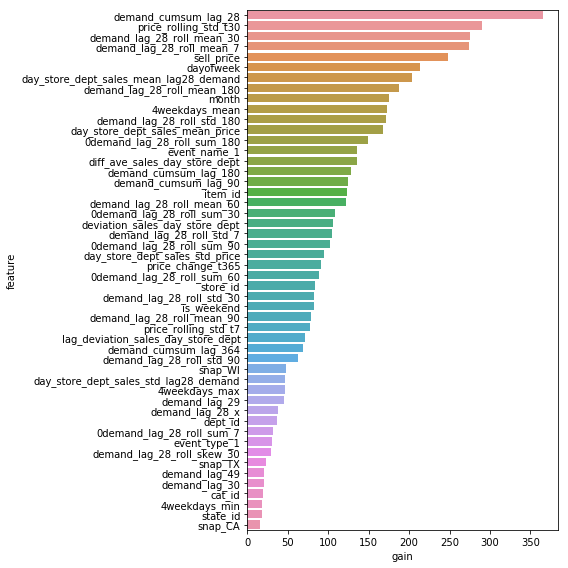

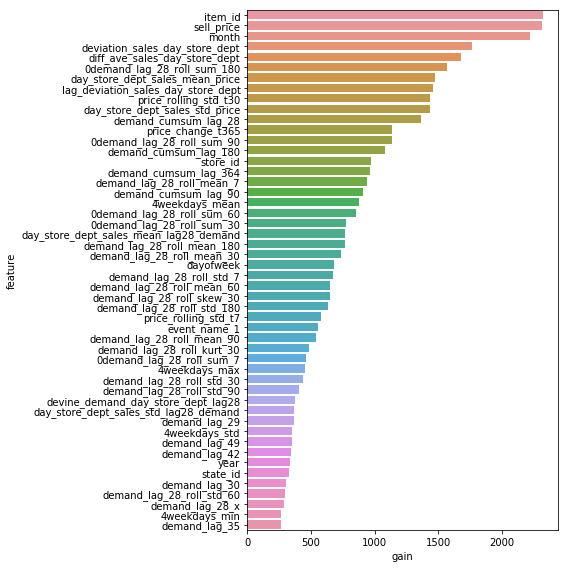

In [147]:
model_list = []
imp_df_list = []
evaluator_list = []
wrmsse_score_list = []
valid_true_df_list = []
valid_pred_df_list = []
eval_result_list = []


for num in ['1st', '2nd']:
    train_end_date = tr_val_date[num]['train_end_date']
    val_end_date = tr_val_date[num]['val_end_date']
    print(f'va:{train_end_date}-{val_end_date}')
    df_train = df_all.query('date <= @train_end_date')
    df_val = df_all.query('date > @train_end_date and date <= @val_end_date')
    print('df_train:{}_df_val:{}'.format(df_train.shape, df_val.shape, ))
    #weightを計算
    print('caluculate_weight...')
    ajust_weight_train = pd.merge(df_train['id'], df_weight, how="left", on="id")['ajust_weight']
    ajust_weight_val = pd.merge(df_val['id'], df_weight, how="left", on="id")['ajust_weight']
    
    if num == '1st':
        train_fold_df = sales_train_validation.copy() #weightの期間を変更
        valid_fold_df = sales_train_validation.iloc[:, -56:-28].copy()
    else:
        train_fold_df = sales_train_validation.copy() #weightの期間を変更
        valid_fold_df = sales_train_validation.iloc[:, -28:].copy()
    valid_true_df_list.append(valid_fold_df)
    
    #インスタンスの作成
    print('build_evaluater...')
    evaluator = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, sell_prices)
    evaluator_list.append(evaluator)
    
    print('train...')
    train_set = lgb.Dataset(df_train[x_features], df_train[target_col], weight=ajust_weight_train)
    val_set = lgb.Dataset(df_val[x_features], df_val[target_col], weight=ajust_weight_val)
    print('train')
    evals_result = {}
    model = lgb.train(
            params,
            train_set,
            num_boost_round=5000,
            early_stopping_rounds=200,
            valid_sets=[train_set, val_set],
    #         feval=evaluator.feval,
            verbose_eval=50)
    # 書き出し
    model_path = os.path.join(result_dir, f'model_{num}.lgb')
    model.save_model(model_path)
    
    # 予測
    y_pred = model.predict(df_test[x_features], num_iteration=model.best_iteration)
    df_test['demand'] += y_pred / 2.
    
    # 重要度
    importances = pd.DataFrame()
    importances['feature'] = x_features
    importances['gain'] = model.feature_importance()
    def save_importances(importances_: pd.DataFrame):
        csv_path = os.path.join(result_dir, f'{num}_importances.csv')
        importances_.to_csv(csv_path, index=False)
        plt.figure(figsize=(8, 8))
        sns.barplot(
            x='gain',
            y='feature',
            data=importances_.sort_values('gain', ascending=False)[:50])
        png_path = os.path.join(result_dir, f'{num}_importances.png')
        plt.tight_layout()
        plt.savefig(png_path)

    save_importances(importances)
    
    model_list.append(model)
    imp_df_list.append(importances)
    eval_result_list.append(evals_result)
    
    #WRMSSEの算出
    id_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    X_val_wide = pred_and_convert_wide(df_val ,x_features, df_val[["id","date"]].copy(), model)
    X_val_wide.columns = ['id'] + ['d_' + str(i + 1) for i in range(tr_val_date[num]['train_end_date_num'], tr_val_date[num]['train_end_date_num']+28)]
    valid_preds = pd.merge(train_fold_df[id_columns].copy(), X_val_wide, how="left",on="id")
    valid_pred_df_list.append(valid_preds)
    #スコアの算出
    wrmsse_score = evaluator.score(valid_preds.iloc[:,6:]) #id列は削除して渡す
    wrmsse_score_list.append(wrmsse_score)
    print("WRMSSE：",round(wrmsse_score, 4))

# 可視化

In [148]:
def plot_timeseries_summary(valid_pred_df_list,valid_true_df_list,sales_train_validation,plot_col):

    sales_train_validation["all"] = 0

    #predsの作成
    id_cols = ["id","item_id","dept_id","cat_id","store_id","state_id","all"] #allを追加
    drop_cols = [x for x in id_cols if x not in plot_col] #plot_colにない値だけを返す

    preds_list = []
    truth_list = []

    for preds, truth in zip(valid_pred_df_list,valid_true_df_list):
        #予測データ
        preds["all"] = 0
        X_val_preds_T = preds.drop(drop_cols,axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})
        preds_list.append(X_val_preds_T)

        #正解データ
        X_val_truth_T = pd.concat([sales_train_validation[plot_col],truth],axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})
        truth_list.append(X_val_truth_T)


    if type(plot_col) == list:
        plot_col = plot_col[0]

    #plot
    n_plot = len(X_val_preds_T.columns)-1
    n_row = math.ceil(n_plot/3)
    plt.figure(figsize=[30,n_row*7])

    if plot_col == "all":
        for i in range(2):
            plt.subplot(n_row,2,i+1)
            for j,col in enumerate(preds_list[i].columns[1:]):
                sns.lineplot(x="day",y=col,data=truth_list[i])
                sns.lineplot(x="day",y=col,data=preds_list[i])
                plt.ylabel("sales")
                plt.xticks(valid_true_df_list[i].columns.tolist()[::7])
                plt.title("all sales in validation{}".format(i),fontsize=18)
                plt.legend(["truth","preds"])

In [149]:
#予測値の可視化（Validation期間）
def plot_timeseries(X_val_preds,valid_fold_df,sales_train_validation,plot_col,n_val):

    sales_train_validation["all"] = 0
    X_val_preds["all"] = 0

    #predsの作成
    id_cols = ["id","item_id","dept_id","cat_id","store_id","state_id","all"] #allを追加
    drop_cols = [x for x in id_cols if x not in plot_col] #plot_colにない値だけを返す
    #予測データ
    X_val_preds_T = X_val_preds.drop(drop_cols,axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})
    #正解データ
    X_val_truth_T = pd.concat([sales_train_validation[plot_col],valid_fold_df],axis=1).groupby(plot_col).sum().T.reset_index().rename(columns={"index":"day"})

    if type(plot_col) == list:
        plot_col = plot_col[0]

    #plot
    n_plot = len(X_val_preds_T.columns)-1
    n_row = math.ceil(n_plot/3)
    plt.figure(figsize=[30,n_row*7])

    if plot_col == "all":
        for i,col in enumerate(X_val_preds_T.columns[1:]):
            sns.lineplot(x="day",y=col,data=X_val_truth_T)
            sns.lineplot(x="day",y=col,data=X_val_preds_T)
            plt.ylabel("sales")
            plt.xticks(valid_fold_df.columns.tolist()[::7])
            plt.title("all sales in validation{}".format(n_val),fontsize=18)
            plt.legend(["truth","preds"])
    
    else:
        for i,col in enumerate(X_val_preds_T.columns[1:]):
            plt.subplot(n_row,3,i+1) #横に3つずつプロットする
            # plt.subplots_adjust(wspace=0.1,top=0.5)
            plt.suptitle("{} validation{}".format(plot_col,n_val),fontsize=24,va="bottom",y=0.9) #super titleの設定
            sns.lineplot(x="day",y=col,data=X_val_truth_T)
            sns.lineplot(x="day",y=col,data=X_val_preds_T)
            plt.ylabel("sales")
            plt.xticks(valid_fold_df.columns.tolist()[::7])
            plt.title("{} sales in validation{}".format(col,n_val),fontsize=18)
            plt.legend(["truth","preds"])


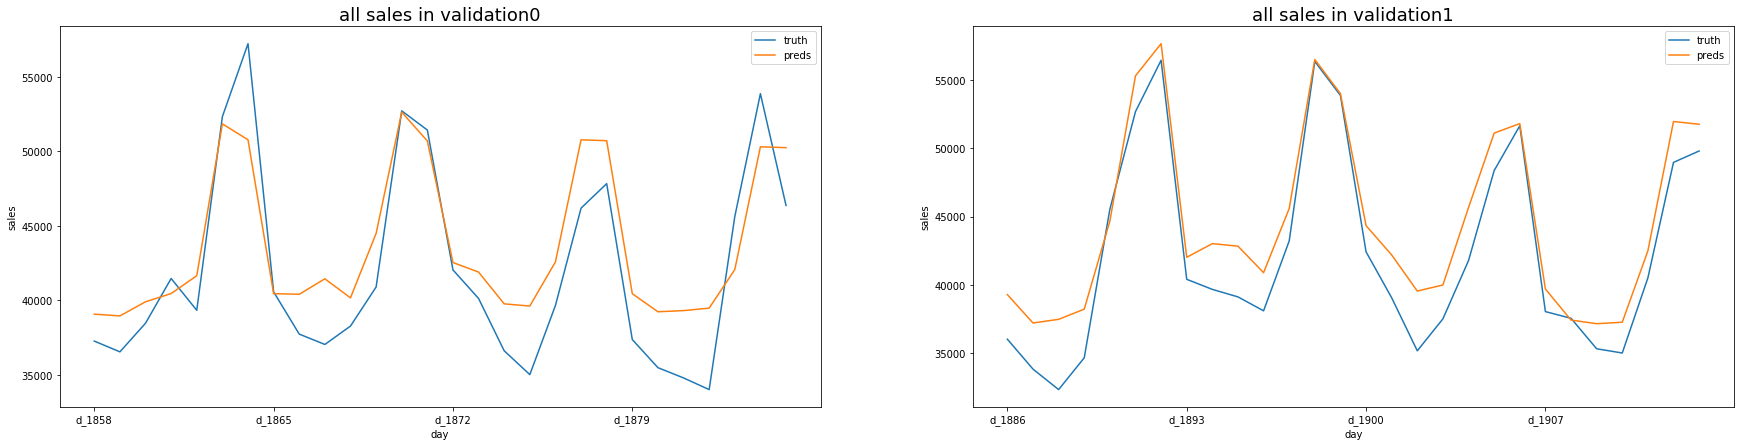

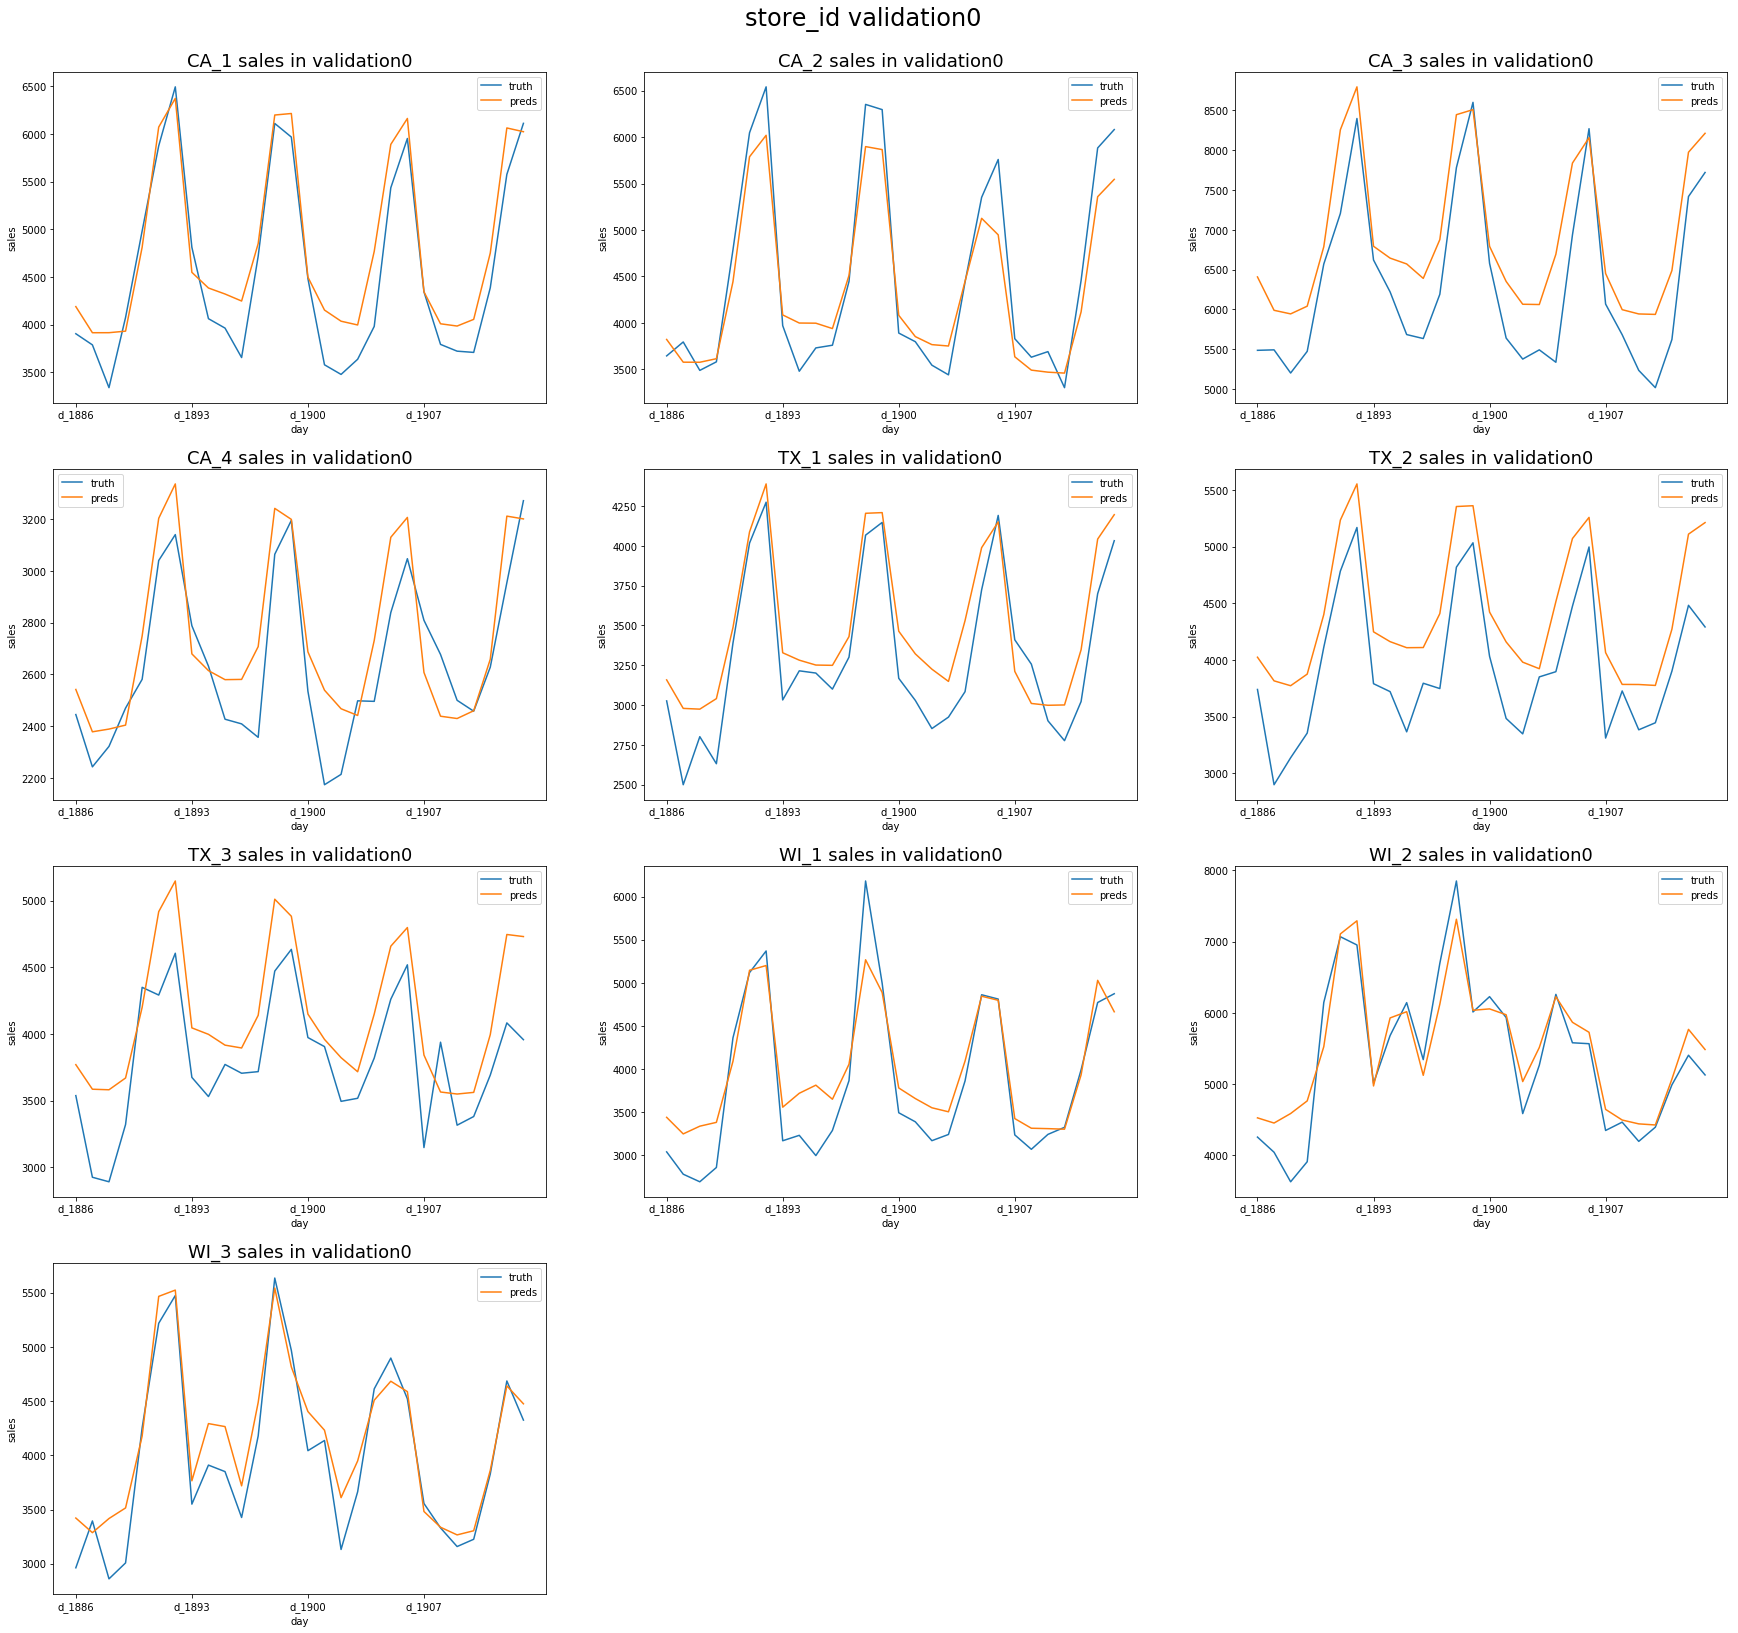

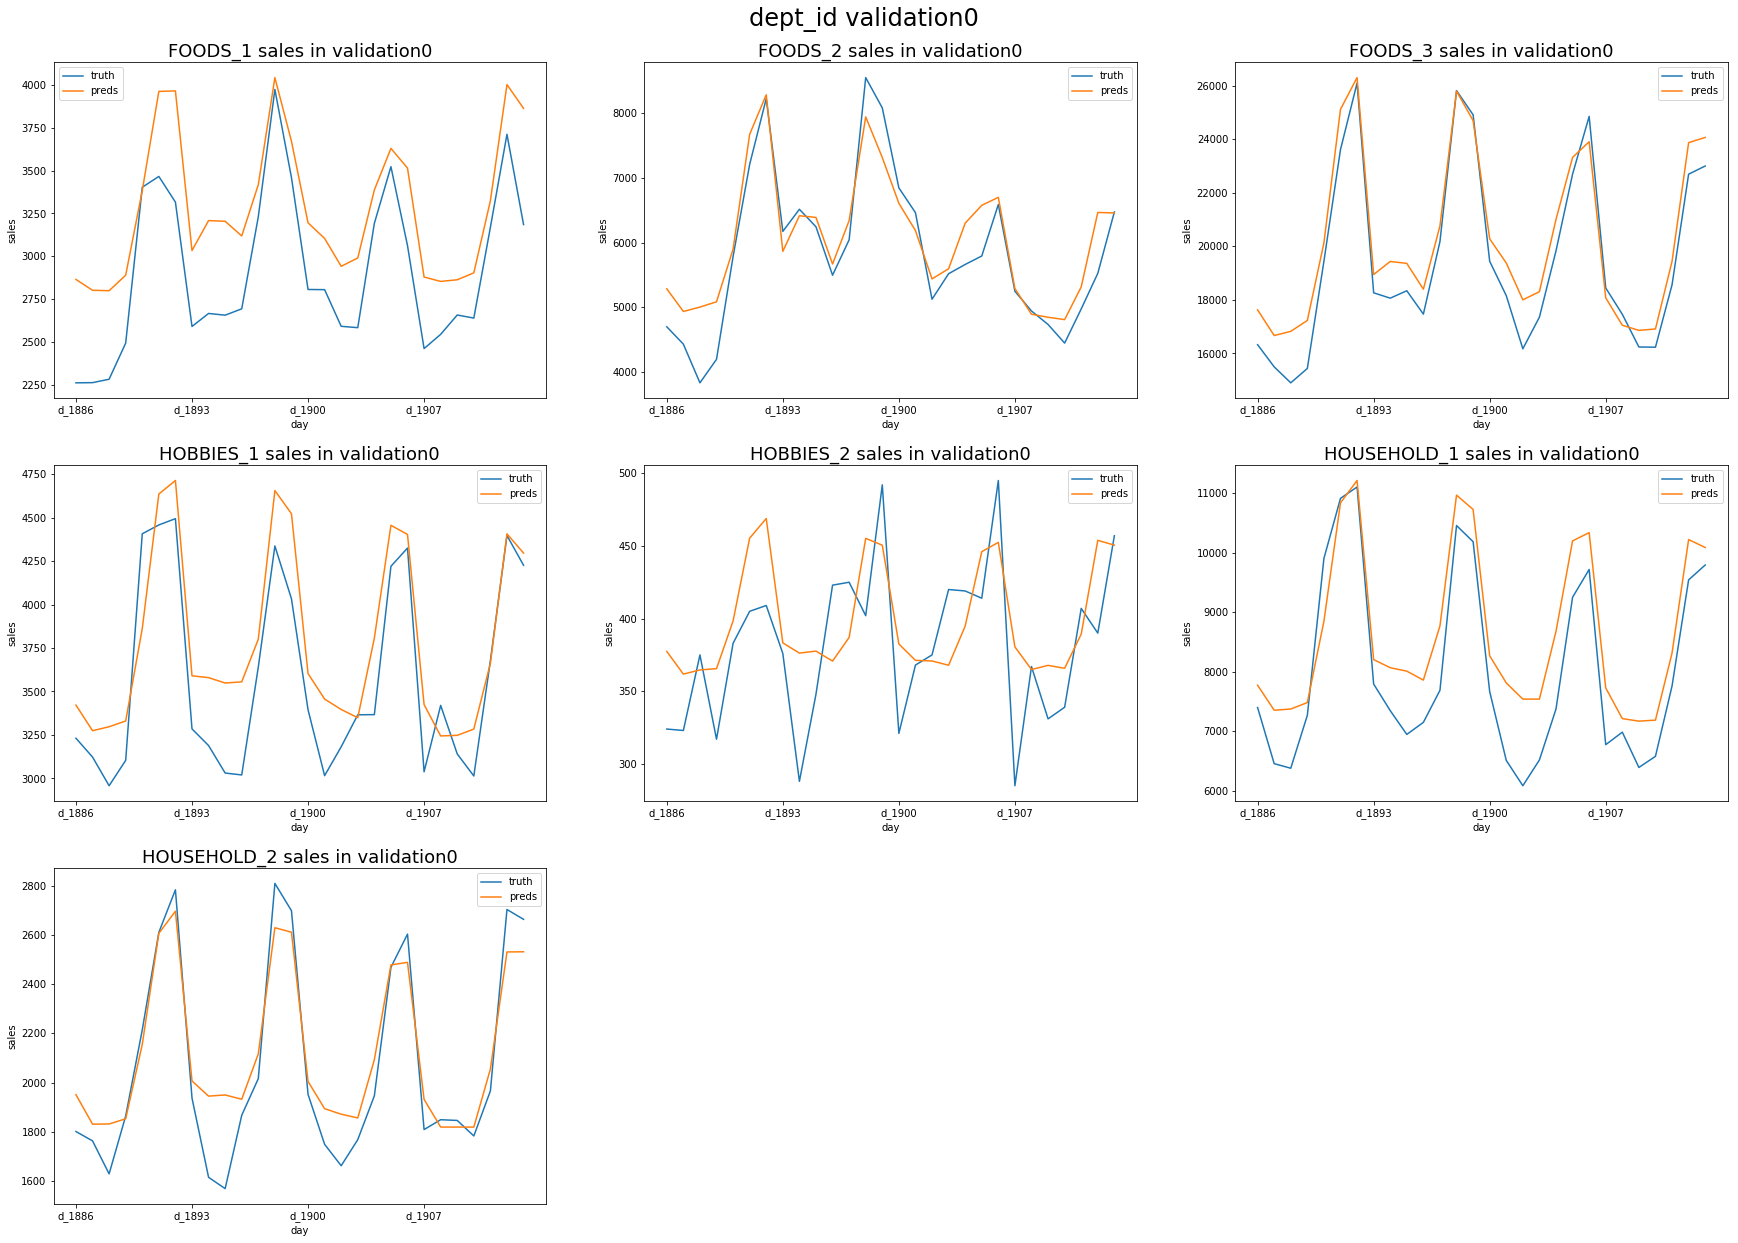

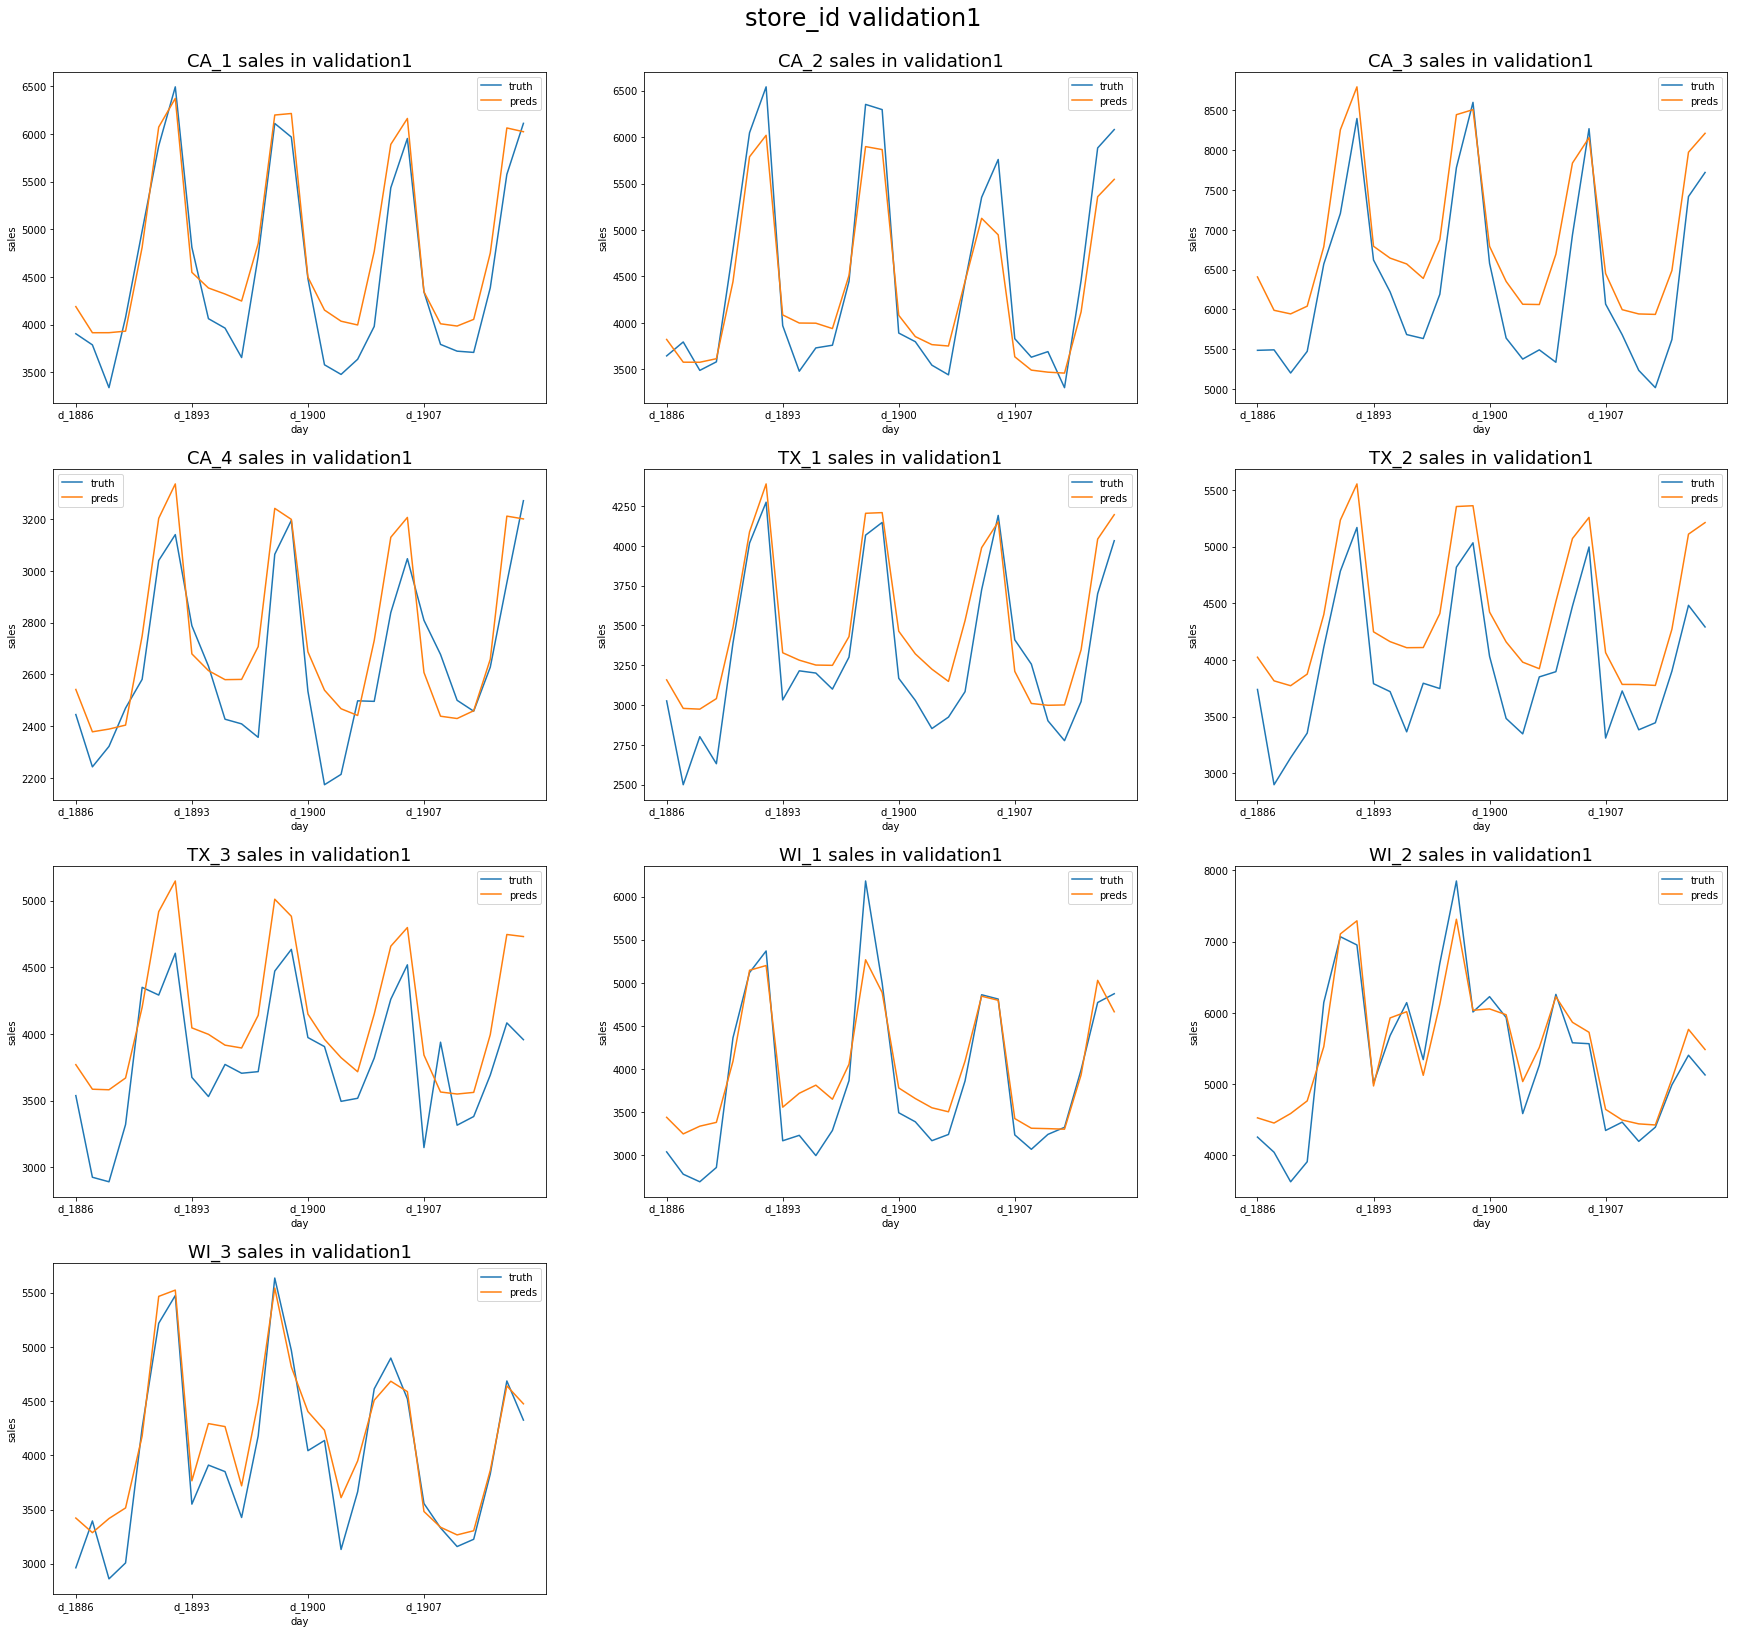

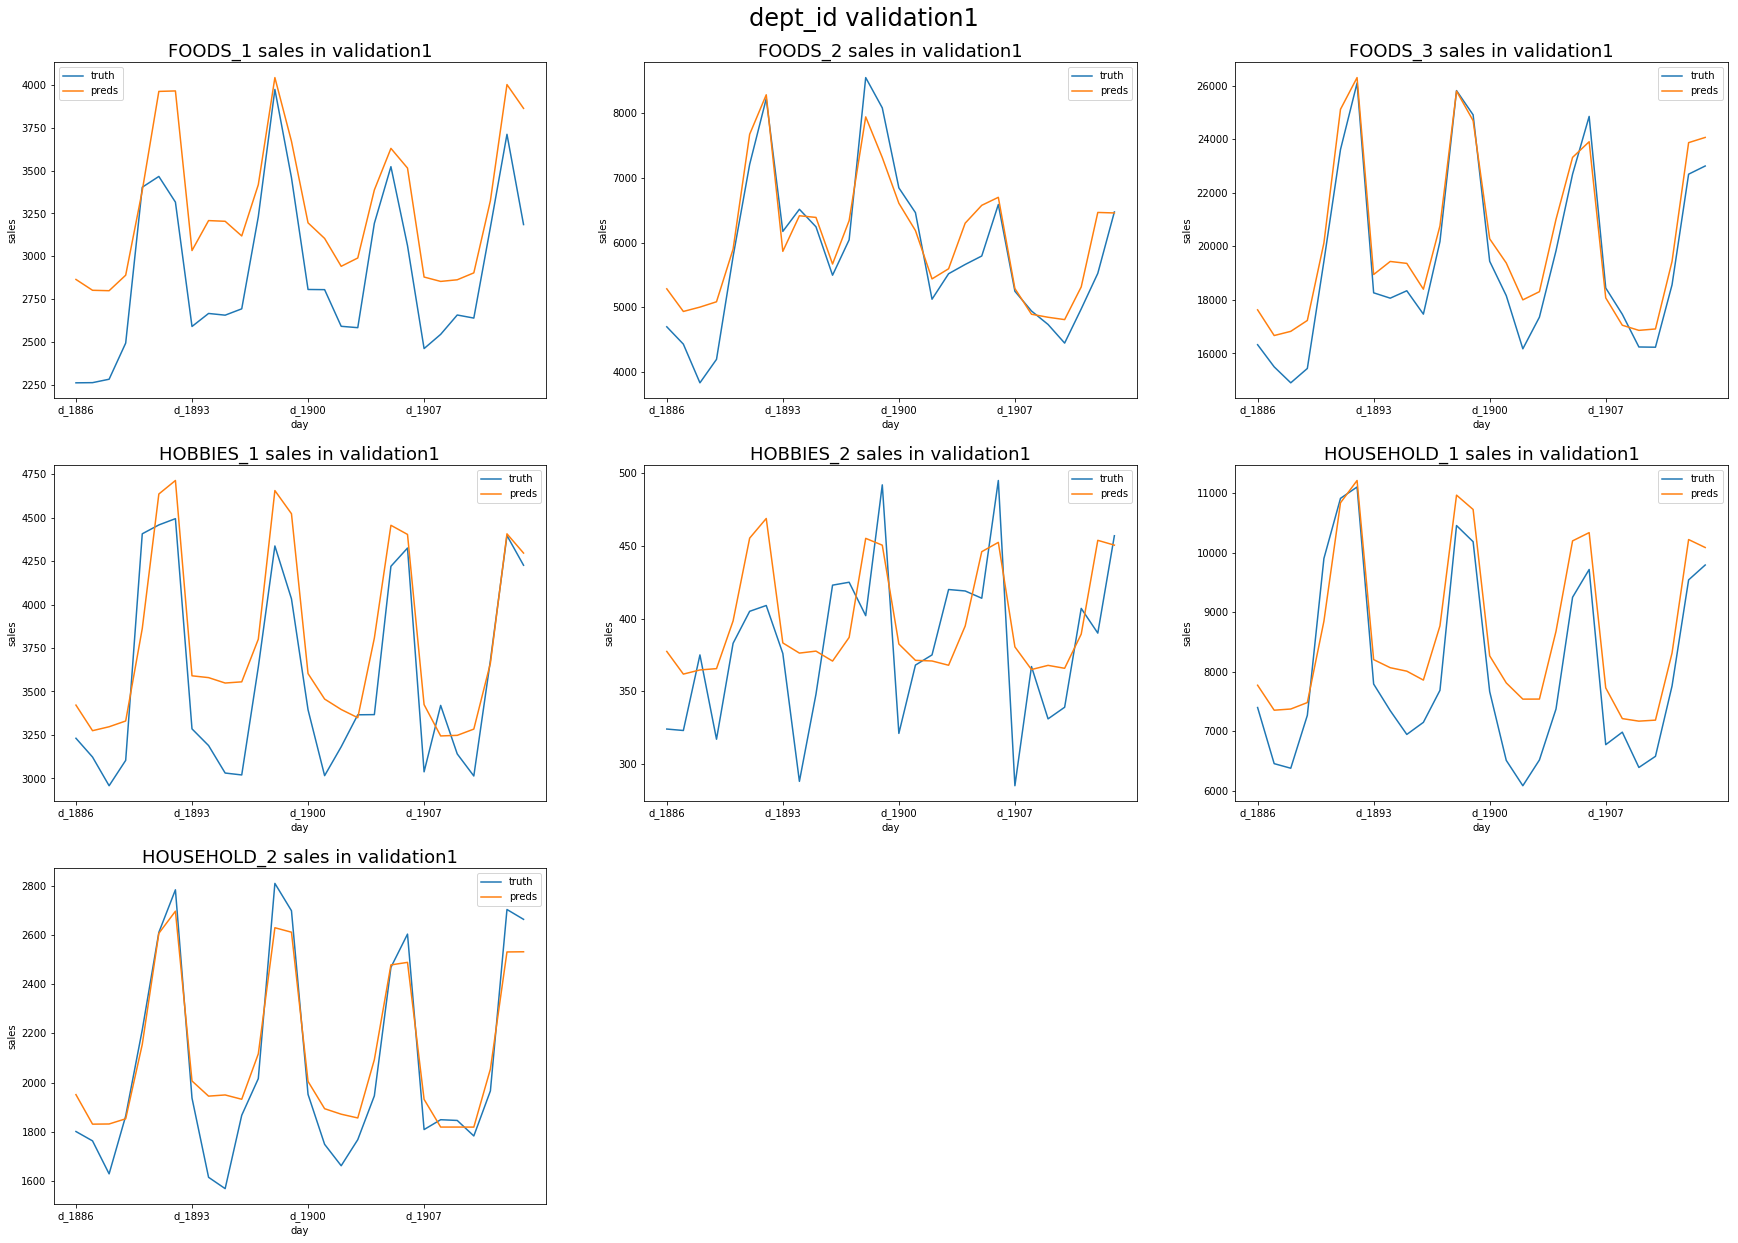

In [150]:
# plot_col_list = ["all","store_id","dept_id"]
plot_col_list = ["store_id","dept_id"]
plot_timeseries_summary(valid_pred_df_list,valid_true_df_list,sales_train_validation,plot_col="all")# allだけ
for i in range(2):
    for plot_col in plot_col_list:
        plot_timeseries(valid_preds,valid_fold_df,sales_train_validation,plot_col,i)

# 書き出し

In [151]:
def predict(test, submission, csv_path):
    predictions = test[['id', 'date', 'demand']]
    predictions = pd.pivot(predictions, index='id', columns='date', values='demand').reset_index()
    predictions.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

    evaluation_rows = [row for row in submission['id'] if 'evaluation' in row]
    evaluation = submission[submission['id'].isin(evaluation_rows)]

    validation = submission[['id']].merge(predictions, on='id')
    final = pd.concat([validation, evaluation])
    print(final.head())
    print(final.shape)
    final.to_csv(csv_path, index=False)

In [153]:
submission = pd.read_csv('../input/sample_submission.csv')
csv_path = os.path.join(result_dir, 'sub.csv')
predict(df_test, submission, csv_path)

                              id        F1        F2        F3        F4  \
0  HOBBIES_1_001_CA_1_validation  0.904030  0.823043  0.780365  0.791048   
1  HOBBIES_1_002_CA_1_validation  0.426827  0.393478  0.391339  0.403551   
2  HOBBIES_1_003_CA_1_validation  0.457550  0.452032  0.438691  0.438283   
3  HOBBIES_1_004_CA_1_validation  2.150702  1.723260  1.732323  1.627412   
4  HOBBIES_1_005_CA_1_validation  0.978652  0.871111  0.988686  1.099059   

         F5        F6        F7        F8        F9  ...       F19       F20  \
0  0.853321  1.055090  1.080419  0.817651  0.860491  ...  0.850194  1.212555   
1  0.411992  0.449244  0.433968  0.295531  0.275812  ...  0.262641  0.316114   
2  0.474927  0.471275  0.568920  0.374573  0.359473  ...  0.475191  0.601014   
3  1.861396  2.209750  2.207839  1.702308  1.680393  ...  1.943461  2.344344   
4  1.146095  1.434340  1.604582  1.220804  1.244500  ...  1.099659  1.364382   

        F21       F22       F23       F24       F25       F26 